In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")
print('Initalized')

Initalized


In [2]:
# place each CSV into it's own data frame since I am trying to predict each body of water flow, volume, and/or hydrometry seperately
Aquifer_Auser = pd.read_csv('Aquifer_Auser.csv')
Aquifer_Doganella = pd.read_csv('Aquifer_Doganella.csv')
Aquifer_Luco = pd.read_csv('Aquifer_Luco.csv')
Aquifer_Petrignano = pd.read_csv('Aquifer_Petrignano.csv')
Lake_Bilancino = pd.read_csv('Lake_Bilancino.csv')
River_Arno = pd.read_csv('River_Arno.csv')
Water_Spring_Amiata = pd.read_csv('Water_Spring_Amiata.csv')
Water_Spring_Lupa = pd.read_csv('Water_Spring_Lupa.csv')
Water_Spring_Madonna_di_Canneto = pd.read_csv('Water_Spring_Madonna_di_Canneto.csv')

# Then print the shape of each DF to look for where I should start analysis (start small work up)
print(f"Water_Spring_Madonna_di_Canneto:{Water_Spring_Madonna_di_Canneto.shape},\nWater_Spring_Lupa:{Water_Spring_Lupa.shape},\nWater_Spring_Amiata:{Water_Spring_Amiata.shape},\nRiver_Arno:{River_Arno.shape},\nLake_Bilancino:{Lake_Bilancino.shape},\nAquifer_Petrignano:{Aquifer_Petrignano.shape},\nAquifer_Luco:{Aquifer_Luco.shape}, \nAquifer_Doganella:{Aquifer_Doganella.shape},\nAquifer_Auser:{Aquifer_Auser.shape}")

Water_Spring_Madonna_di_Canneto:(3113, 4),
Water_Spring_Lupa:(4199, 3),
Water_Spring_Amiata:(7487, 16),
River_Arno:(8217, 17),
Lake_Bilancino:(6603, 9),
Aquifer_Petrignano:(5223, 8),
Aquifer_Luco:(7487, 22), 
Aquifer_Doganella:(6026, 22),
Aquifer_Auser:(8154, 27)


After looking at the shape of each DF I will start with Water_Spring_Lupa as it has the least amount of features to work with. Let's start by looking at the basics of the data looking at descirption, columns, trying to find distributions, etc

In [3]:
Water_Spring_Lupa.columns

Index(['Date', 'Rainfall_Terni', 'Flow_Rate_Lupa'], dtype='object')

In [4]:
Water_Spring_Lupa.describe()

,Rainfall_Terni,Flow_Rate_Lupa
count,4199.000000,3817.000000
mean,2.466355,-97.712916
std,2.041837,15.026314
min,0.000000,-182.310000
25%,1.402000,-105.760000
50%,2.142000,-96.590000
75%,3.165000,-87.220000
max,76.000000,0.000000


In [5]:
Water_Spring_Lupa.dtypes

Date               object
Rainfall_Terni    float64
Flow_Rate_Lupa    float64
dtype: object

In [6]:
print(Water_Spring_Lupa.isnull().sum()/Water_Spring_Lupa.shape[0] * 100)
print()
print(f"Number of missing Flow_Rate_Lupa values: {Water_Spring_Lupa['Flow_Rate_Lupa'].isnull().sum()/Water_Spring_Lupa.shape[0] * Water_Spring_Lupa.shape[0]}")


Date              0.000000
Rainfall_Terni    0.000000
Flow_Rate_Lupa    9.097404
dtype: float64

Number of missing Flow_Rate_Lupa values: 382.0


Less than 10% of the target variable data is missing. However, due to this problem being a time series problem, we do not want to drop the null values Imputing the null values for the target variable can be tricky and cause issues.  My current assumption is that there is seaonalility AND trend present in the data. Let's explore further.

In [7]:
Water_Spring_Lupa['Date']

0       01/01/2009
1       02/01/2009
2       03/01/2009
3       04/01/2009
4       05/01/2009
           ...    
4194    26/06/2020
4195    27/06/2020
4196    28/06/2020
4197    29/06/2020
4198    30/06/2020
Name: Date, Length: 4199, dtype: object

In [8]:
# First we need to convert the date object into a datetime object
Water_Spring_Lupa['Date'] = pd.to_datetime(Water_Spring_Lupa['Date'])
# Then we need to sort the index by date and assign it to the the index
Water_Spring_Lupa = Water_Spring_Lupa.sort_values(by='Date')
Water_Spring_Lupa.set_index('Date', inplace = True)

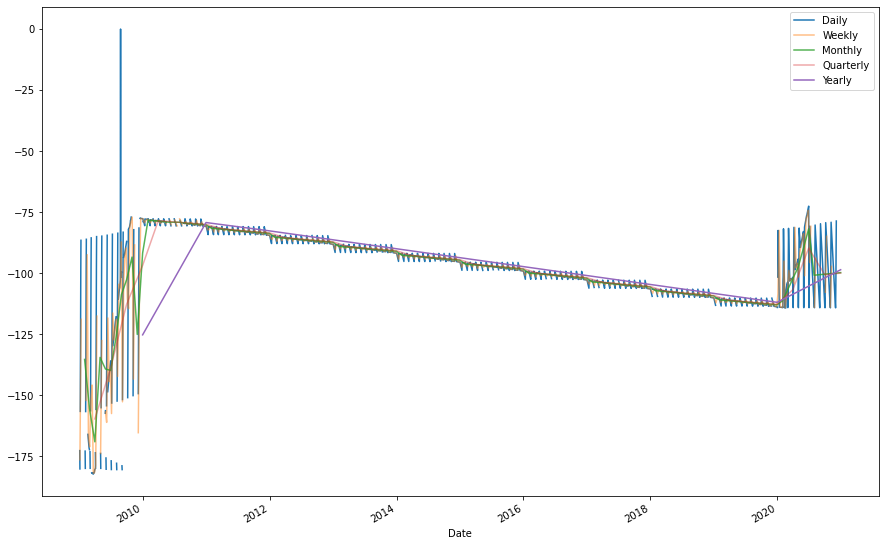

In [9]:
# Finally, let's look at the flow rate(target variable) in at different time intervals. Since we are looking at a usage metric, mean is the best aggreation.
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Flow_Rate_Lupa'].plot(label='Daily')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Q').mean().plot(alpha=.4, label='Quarterly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Y').mean().plot(label='Yearly')
plt.legend()

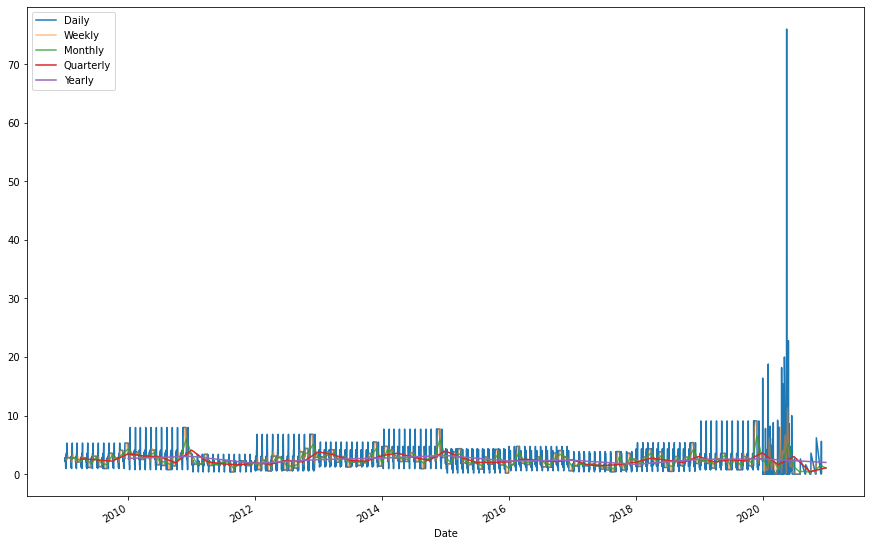

In [10]:
# let's look at the rainfall in different break downs
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Rainfall_Terni'].plot(label='Daily')
Water_Spring_Lupa['Rainfall_Terni'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Rainfall_Terni'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Rainfall_Terni'].resample('Q').mean().plot(label='Quarterly')
Water_Spring_Lupa['Rainfall_Terni'].resample('Y').mean().plot(label='Yearly')
plt.legend()

Flow data appearsto be inconsistent prior to 2010 while rainfall data appears to be realatively consistent throughout the whole data set. Since flow is the target variable, it is advised to trim the data to be 2010-2020. Additional triming maybe required due to the outliers that exist in rain data for 2020. 

In [11]:
# Trim the DFto ignore year 2009
Water_Spring_Lupa = Water_Spring_Lupa[Water_Spring_Lupa.index > "2009-12-31"]

# Find instances where the flow rate is null
Water_Spring_Lupa[Water_Spring_Lupa['Flow_Rate_Lupa'].isnull()]

,Rainfall_Terni,Flow_Rate_Lupa
Date,,
2010-01-06,1.597,NaN
2010-01-07,1.477,NaN
2010-01-08,0.758,NaN
2010-02-06,1.597,NaN
2010-02-07,1.477,NaN
...,...,...
2019-08-19,0.733,NaN
2019-09-10,1.436,NaN
2019-10-10,1.436,NaN


In [12]:
for year in range(2012, 2021):
    print(f'{year} \n{Water_Spring_Lupa[Water_Spring_Lupa.index.year == year].isnull().sum()} \n')

2012 
Rainfall_Terni     0
Flow_Rate_Lupa    14
dtype: int64 

2013 
Rainfall_Terni     0
Flow_Rate_Lupa    12
dtype: int64 

2014 
Rainfall_Terni     0
Flow_Rate_Lupa    14
dtype: int64 

2015 
Rainfall_Terni     0
Flow_Rate_Lupa    14
dtype: int64 

2016 
Rainfall_Terni     0
Flow_Rate_Lupa    14
dtype: int64 

2017 
Rainfall_Terni     0
Flow_Rate_Lupa    12
dtype: int64 

2018 
Rainfall_Terni     0
Flow_Rate_Lupa    14
dtype: int64 

2019 
Rainfall_Terni     0
Flow_Rate_Lupa    14
dtype: int64 

2020 
Rainfall_Terni    0
Flow_Rate_Lupa    1
dtype: int64 



In [13]:
# For the time being, I will inpute null values with the monthly mean for each month with null values

# Create a year_month columns
Water_Spring_Lupa['year_month'] = Water_Spring_Lupa.index.strftime('%Y-%m')
# Reset the index in order to keep the date column after merging
Water_Spring_Lupa = Water_Spring_Lupa.reset_index()

# Create an avg_flow DF that groups by the year_month column to get the avg monthly flow rate
avg_flow = Water_Spring_Lupa[['Flow_Rate_Lupa', 'year_month']].groupby('year_month').mean()
avg_flow.columns = ['avg_flow']

# Take the original Water_Spring_Lupa DF and merge it with the avg_flow on the year_month column to pair the avg_flow with each date
Water_Spring_Lupa = Water_Spring_Lupa.merge(avg_flow, how='left', on='year_month')
# Set the index back to date
Water_Spring_Lupa = Water_Spring_Lupa.set_index('Date')
# Use np.where function to replace 
Water_Spring_Lupa['Flow_Rate_Lupa'] = np.where(Water_Spring_Lupa['Flow_Rate_Lupa'].isnull(), 
                                               Water_Spring_Lupa['avg_flow'], Water_Spring_Lupa['Flow_Rate_Lupa'])

#Drop avg_flow column 
Water_Spring_Lupa.drop(columns=['avg_flow'], inplace=True)
Water_Spring_Lupa

,Rainfall_Terni,Flow_Rate_Lupa,year_month
Date,,,
2010-01-01,3.273,-77.69,2010-01
2010-01-02,3.739,-78.00,2010-01
2010-01-03,2.508,-78.28,2010-01
2010-01-04,3.165,-79.11,2010-01
2010-01-05,4.100,-78.89,2010-01
...,...,...,...
2020-12-02,0.200,-114.19,2020-12
2020-12-03,0.000,-103.34,2020-12
2020-12-04,0.000,-98.80,2020-12


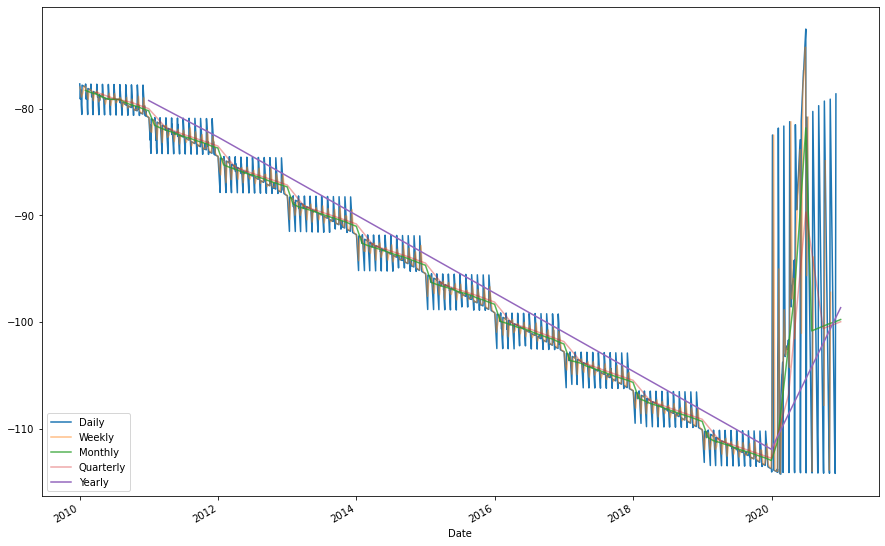

In [14]:
# Finally, let's look at the flow rate(target variable) in at different time intervals. Since we are looking at a usage metric, mean is the best aggreation.
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Flow_Rate_Lupa'].plot(label='Daily')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Q').mean().plot(alpha=.4, label='Quarterly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Y').mean().plot(label='Yearly')
plt.legend()

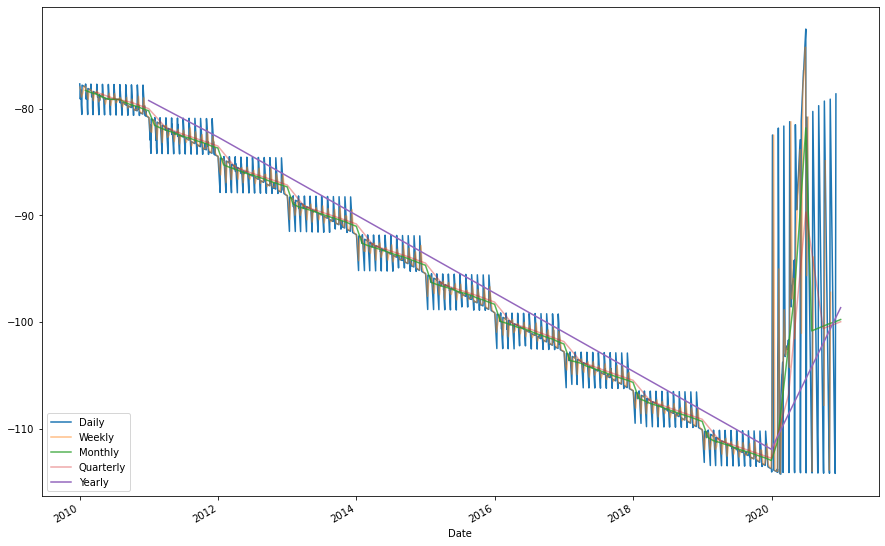

In [15]:
# Finally, let's look at the flow rate(target variable) in at different time intervals. Since we are looking at a usage metric, mean is the best aggreation.
plt.figure(figsize=(15,10))
Water_Spring_Lupa['Flow_Rate_Lupa'].plot(label='Daily')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('W').mean().plot(alpha=.5, label='Weekly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('M').mean().plot(alpha=.8, label='Monthly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Q').mean().plot(alpha=.4, label='Quarterly')
Water_Spring_Lupa['Flow_Rate_Lupa'].resample('Y').mean().plot(label='Yearly')
plt.legend()

There appears to be seaonaility in the data where the 12 or 13th day of each month has a reset period

<AxesSubplot:xlabel='Date'>

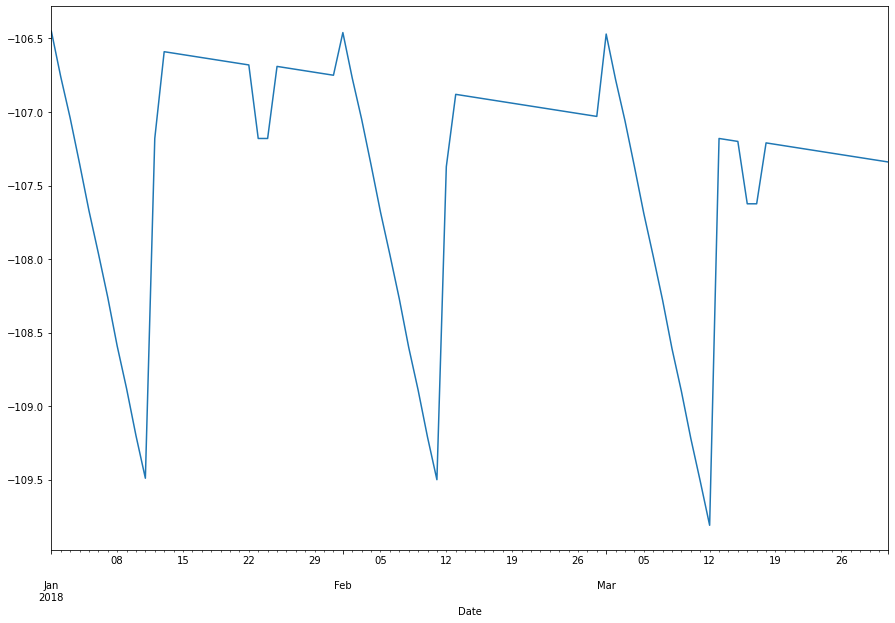

In [16]:
plt.figure(figsize=(15,10))
Water_Spring_Lupa[(Water_Spring_Lupa['year_month'] < '2018-04') & (Water_Spring_Lupa['year_month'] >= '2018-01')]['Flow_Rate_Lupa'].plot(label='Daily')


<AxesSubplot:xlabel='Date'>

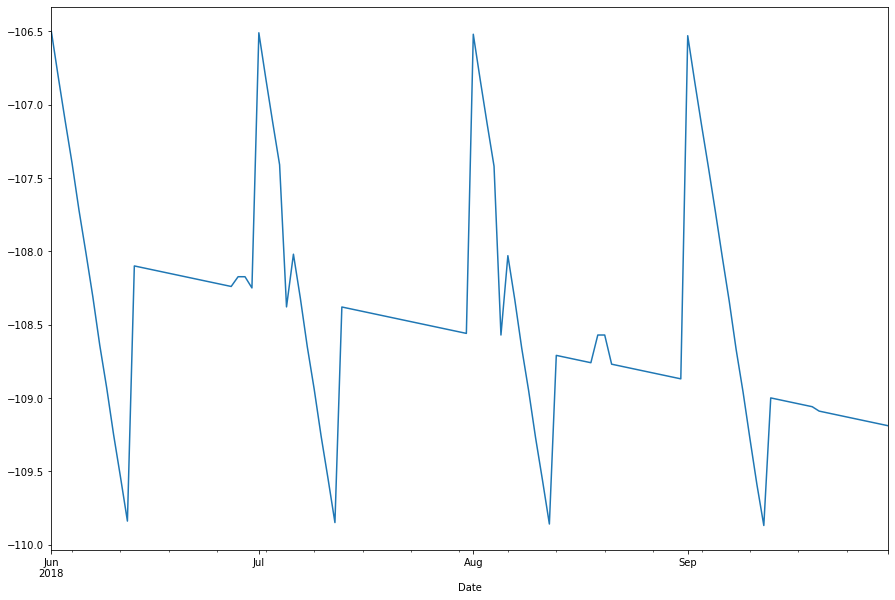

In [17]:
plt.figure(figsize=(15,10))
Water_Spring_Lupa[(Water_Spring_Lupa['year_month'] <= '2018-09') & (Water_Spring_Lupa['year_month'] >= '2018-06')]['Flow_Rate_Lupa'].plot(label='Daily')


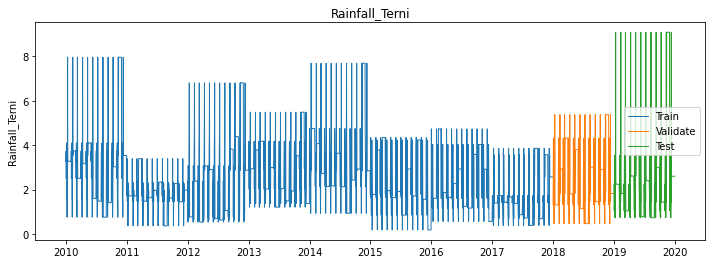

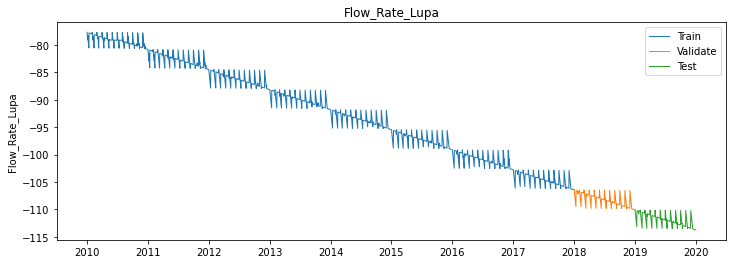

In [18]:
# In order to deal with the remaining outliers, I'm going to simply remove the year 2020 from the data as well for the time being
Lupa_Cleaned = Water_Spring_Lupa[Water_Spring_Lupa['year_month'] < '2020-01']
Lupa_Cleaned['year'] = Lupa_Cleaned.index.strftime('%Y').astype('int')


train = Lupa_Cleaned[Lupa_Cleaned['year'] < 2018]
validate = Lupa_Cleaned[(Lupa_Cleaned['year'] == 2018)] 
test = Lupa_Cleaned[Lupa_Cleaned['year'] == 2019]

# After getting the train, validate, and test splits created resample them to month

columns = ['Rainfall_Terni', 'Flow_Rate_Lupa']

for col in columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col], label = 'Train', linewidth = 1)
    plt.plot(validate[col], label = 'Validate', linewidth = 1)
    plt.plot(test[col], label = 'Test', linewidth = 1)
    plt.ylabel(col)
    plt.title(col)
    plt.legend()
    plt.show()

In [19]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Prediction', linewidth = 2)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

eval_df

,model_type,target_var,rmse


In [20]:
flow = train['Flow_Rate_Lupa'][-1:][0]

yhat_df = pd.DataFrame({'Flow_Rate_Lupa': [flow]}, 
                       index = validate.index)

yhat_df.head(2)

,Flow_Rate_Lupa
Date,
2018-01-01,-106.44
2018-01-02,-106.44


Flow_Rate_Lupa -- RMSE: 2


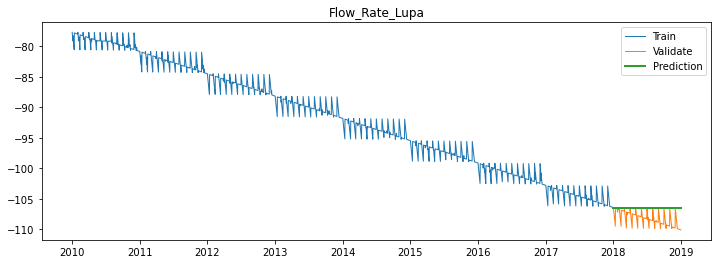

In [21]:
plot_and_eval('Flow_Rate_Lupa')

In [22]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'Flow_Rate_Lupa')

eval_df

,model_type,target_var,rmse
0,last_observed_value,Flow_Rate_Lupa,2.0


            Flow_Rate_Lupa
Date                      
2018-01-01          -91.84
2018-01-02          -91.84
Flow_Rate_Lupa -- RMSE: 16


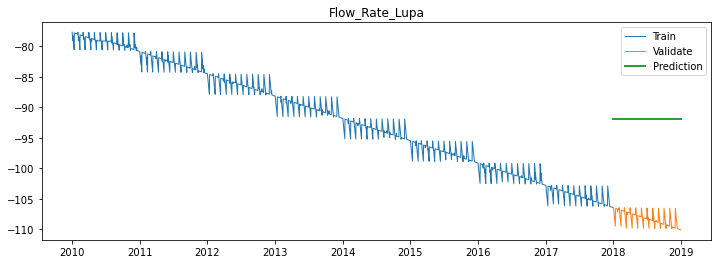

            model_type      target_var  rmse
0  last_observed_value  Flow_Rate_Lupa   2.0
1       simple_average  Flow_Rate_Lupa  16.0


In [23]:
flow = round(train['Flow_Rate_Lupa'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'Flow_Rate_Lupa': [flow],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

eval_df = append_eval_df(model_type='simple_average', target_var = 'Flow_Rate_Lupa')


print(yhat_df.head(2))
plot_and_eval('Flow_Rate_Lupa')

print(eval_df)

Flow_Rate_Lupa -- RMSE: 2


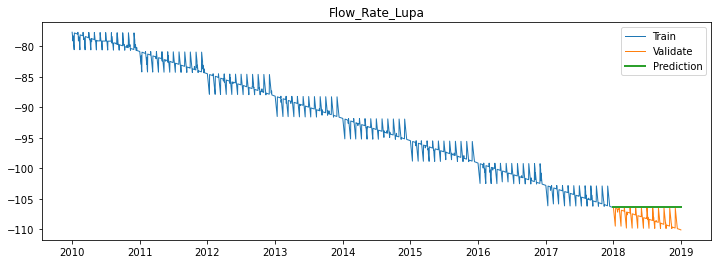

            model_type      target_var  rmse
0  last_observed_value  Flow_Rate_Lupa   2.0
1       simple_average  Flow_Rate_Lupa  16.0
2    7 Day Rolling AVG  Flow_Rate_Lupa   2.0


In [24]:
# Do a 7 day rolling average

period = 7

flow = round(train['Flow_Rate_Lupa'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()

eval_df = append_eval_df(model_type='7 Day Rolling AVG', target_var = 'Flow_Rate_Lupa')
    


plot_and_eval('Flow_Rate_Lupa')

print(eval_df)

Flow_Rate_Lupa -- RMSE: 3


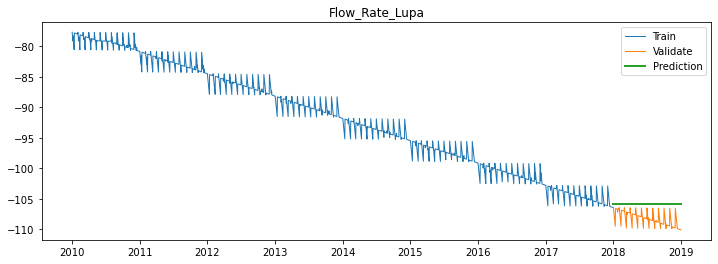

            model_type      target_var  rmse
0  last_observed_value  Flow_Rate_Lupa   2.0
1       simple_average  Flow_Rate_Lupa  16.0
2    7 Day Rolling AVG  Flow_Rate_Lupa   2.0
3   48 Day Rolling AVG  Flow_Rate_Lupa   3.0


In [25]:
# Do a 48 day rolling average

period = 48

flow = round(train['Flow_Rate_Lupa'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()

eval_df = append_eval_df(model_type='48 Day Rolling AVG', target_var = 'Flow_Rate_Lupa')
    


plot_and_eval('Flow_Rate_Lupa')

print(eval_df)

In [26]:
# get the min rmse for each variable

min_rmse_flow = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[eval_df.rmse == min_rmse_flow]

,model_type,target_var,rmse
0,last_observed_value,Flow_Rate_Lupa,2.0
2,7 Day Rolling AVG,Flow_Rate_Lupa,2.0


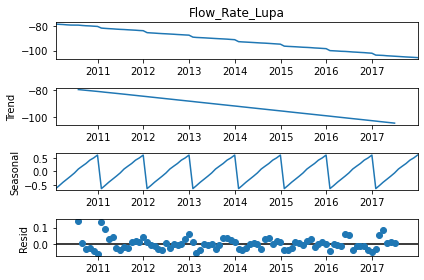

In [27]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train['Flow_Rate_Lupa'].resample('M').mean()).plot()
plt.show()

Flow_Rate_Lupa -- RMSE: 10


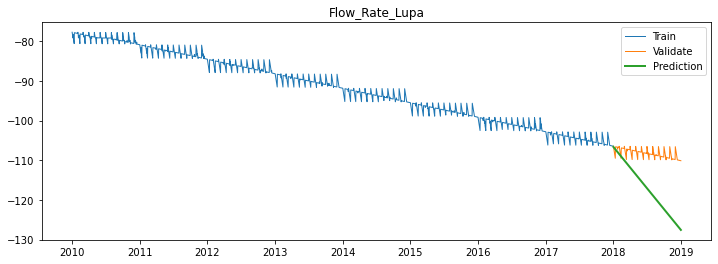

In [28]:
model = Holt(train['Flow_Rate_Lupa'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_df = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['Flow_Rate_Lupa'] = round(yhat_df, 2)

plot_and_eval(target_var = 'Flow_Rate_Lupa')

In [29]:
eval_df = append_eval_df(model_type = 'Holts 1', target_var = 'Flow_Rate_Lupa')
eval_df

,model_type,target_var,rmse
0,last_observed_value,Flow_Rate_Lupa,2.0
1,simple_average,Flow_Rate_Lupa,16.0
2,7 Day Rolling AVG,Flow_Rate_Lupa,2.0
3,48 Day Rolling AVG,Flow_Rate_Lupa,3.0
4,Holts 1,Flow_Rate_Lupa,10.0


Flow_Rate_Lupa -- RMSE: 3


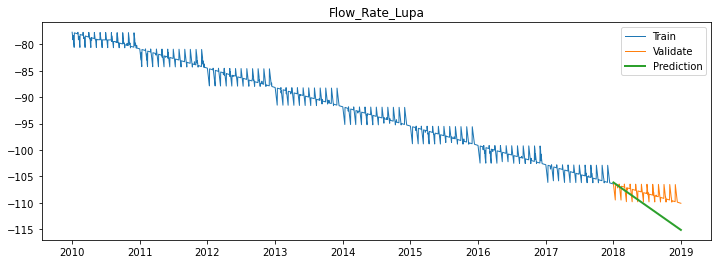

,model_type,target_var,rmse
0,last_observed_value,Flow_Rate_Lupa,2.0
1,simple_average,Flow_Rate_Lupa,16.0
2,7 Day Rolling AVG,Flow_Rate_Lupa,2.0
3,48 Day Rolling AVG,Flow_Rate_Lupa,3.0
4,Holts 1,Flow_Rate_Lupa,10.0
5,Holts 2,Flow_Rate_Lupa,3.0


In [30]:
model = Holt(train['Flow_Rate_Lupa'], exponential = False)
model = model.fit(smoothing_level = .05, 
                  smoothing_slope = .05, 
                  optimized = False)
yhat_df = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['Flow_Rate_Lupa'] = round(yhat_df, 2)

plot_and_eval(target_var = 'Flow_Rate_Lupa')


eval_df = append_eval_df(model_type = 'Holts 2', target_var = 'Flow_Rate_Lupa')
eval_df

### Holts 3

Flow_Rate_Lupa -- RMSE: 1


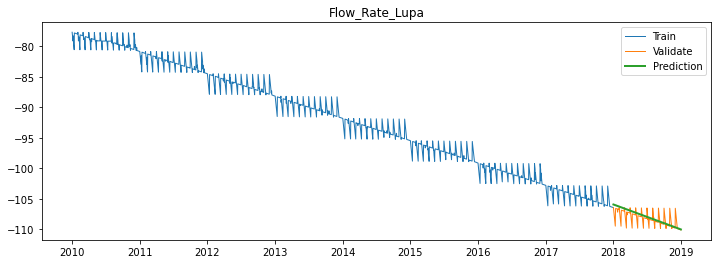

,model_type,target_var,rmse
0,last_observed_value,Flow_Rate_Lupa,2.0
1,simple_average,Flow_Rate_Lupa,16.0
2,7 Day Rolling AVG,Flow_Rate_Lupa,2.0
3,48 Day Rolling AVG,Flow_Rate_Lupa,3.0
4,Holts 1,Flow_Rate_Lupa,10.0
5,Holts 2,Flow_Rate_Lupa,3.0
6,Holts 3,Flow_Rate_Lupa,1.0


In [31]:
model = Holt(train['Flow_Rate_Lupa'], exponential = False)
model = model.fit(smoothing_level = .025, 
                  smoothing_slope = .025, 
                  optimized = False)
yhat_df = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['Flow_Rate_Lupa'] = round(yhat_df, 2)

plot_and_eval(target_var = 'Flow_Rate_Lupa')


eval_df = append_eval_df(model_type = 'Holts 3', target_var = 'Flow_Rate_Lupa')
eval_df

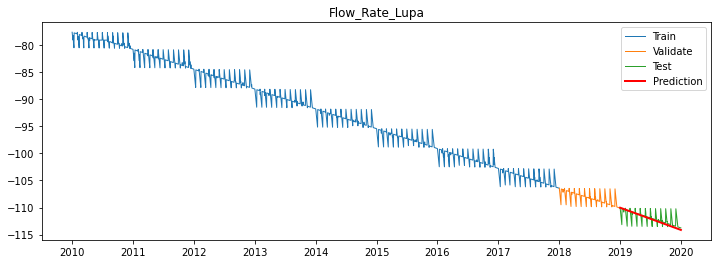

In [32]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], label='Prediction', color='red', linewidth = 2)
    plt.title(target_var)
    plt.legend()
    plt.show()

yhat_df = model.predict(start = test.index[0], 
                           end = test.index[-1])


yhat_df['Flow_Rate_Lupa'] = round(yhat_df, 2)

plot_and_eval(target_var = 'Flow_Rate_Lupa')

# Lupa Monthly

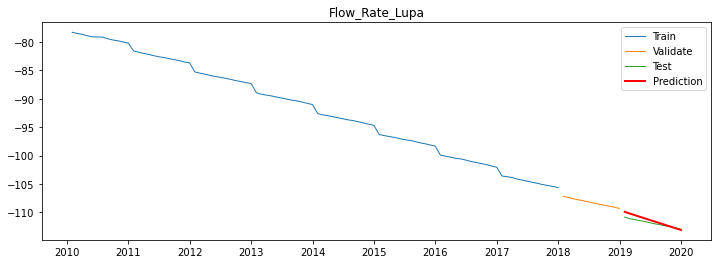

In [33]:
m_train = train.resample('M').mean()
m_validate = validate.resample('M').mean()
m_test = test.resample('M').mean()

# previous testing revealed that Holt1 model was best observed (will split it up later)
model = Holt(m_train['Flow_Rate_Lupa'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)

yhat_df = model.predict(start = m_test.index[0], 
                           end = m_test.index[-1])


yhat_df['Flow_Rate_Lupa'] = round(yhat_df, 2)


def m_plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(m_train[target_var], label = 'Train', linewidth = 1)
    plt.plot(m_validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(m_test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], label='Prediction', color='red', linewidth = 2)
    plt.title(target_var)
    plt.legend()
    plt.show()

m_plot_and_eval(target_var = 'Flow_Rate_Lupa')


In [34]:
yhat_df

2019-01-31 00:00:00                                             -109.911
2019-02-28 00:00:00                                             -110.201
2019-03-31 00:00:00                                             -110.492
2019-04-30 00:00:00                                             -110.782
2019-05-31 00:00:00                                             -111.072
2019-06-30 00:00:00                                             -111.363
2019-07-31 00:00:00                                             -111.653
2019-08-31 00:00:00                                             -111.943
2019-09-30 00:00:00                                             -112.233
2019-10-31 00:00:00                                             -112.524
2019-11-30 00:00:00                                             -112.814
2019-12-31 00:00:00                                             -113.104
Flow_Rate_Lupa         2019-01-31   -109.91
2019-02-28   -110.20
2019...
dtype: object

# Water_Spring_Madonna_di_Canneto

In [35]:
Water_Spring_Madonna_di_Canneto

,Date,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
0,01/01/2012,0.0,5.25,NaN
1,02/01/2012,5.6,6.65,NaN
2,03/01/2012,10.0,8.85,NaN
3,04/01/2012,0.0,6.75,NaN
4,05/01/2012,1.0,5.55,NaN
...,...,...,...,...
3108,NaN,NaN,NaN,NaN
3109,NaN,NaN,NaN,NaN
3110,NaN,NaN,NaN,NaN
3111,NaN,NaN,NaN,NaN


In [36]:
# assign Water_Spring_Madonna_di_Canneto df to wsmc df
wsmc = Water_Spring_Madonna_di_Canneto 

# find how many null values each column has
wsmc.isnull().sum()

Date                               9
Rainfall_Settefrati              556
Temperature_Settefrati           556
Flow_Rate_Madonna_di_Canneto    1726
dtype: int64

In [37]:
# Find which dates are missing
wsmc[wsmc['Date'].isnull()]

,Date,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
3104,NaN,NaN,NaN,NaN
3105,NaN,NaN,NaN,NaN
3106,NaN,NaN,NaN,NaN
3107,NaN,NaN,NaN,NaN
3108,NaN,NaN,NaN,NaN
3109,NaN,NaN,NaN,NaN
3110,NaN,NaN,NaN,NaN
3111,NaN,NaN,NaN,NaN
3112,NaN,NaN,NaN,NaN


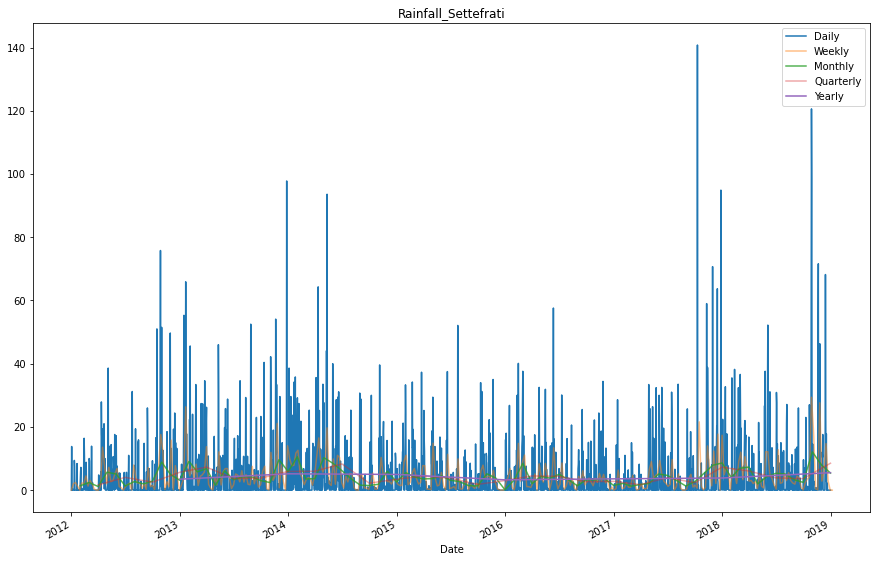

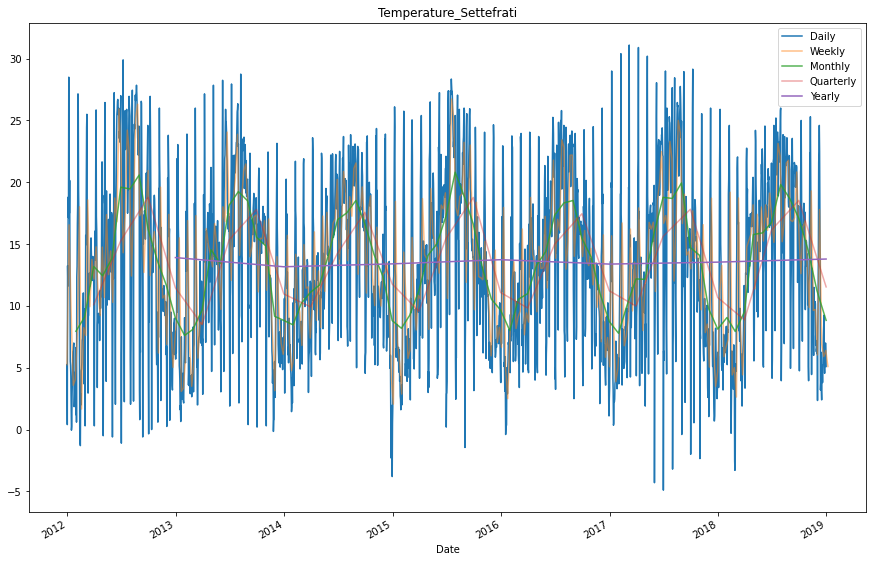

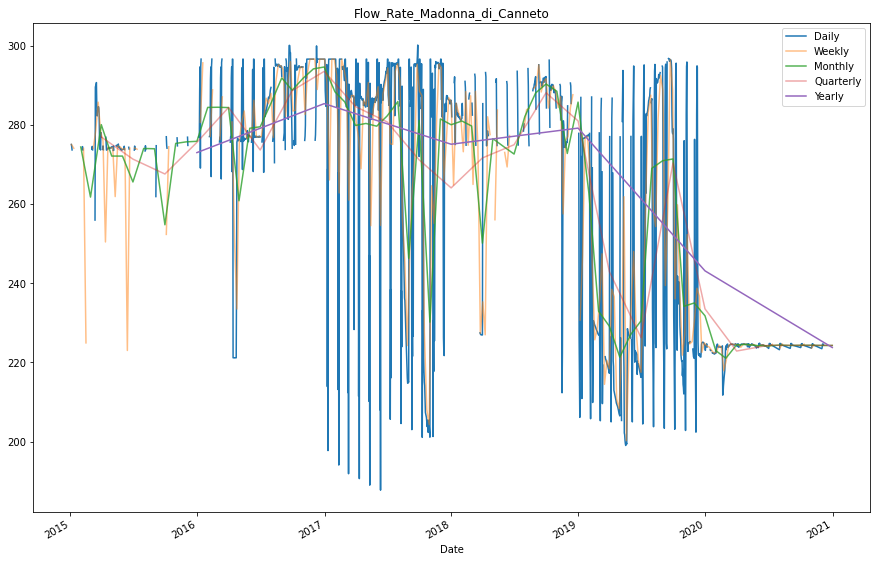

In [38]:
# Drop the null dates as they are at the end of the data frame and have no other assoicated values
wsmc.dropna(subset=['Date'], inplace = True)

# Convert Date into a datetime obj
wsmc['Date'] = pd.to_datetime(wsmc['Date'])
# Then we need to sort the index by date and assign it to the the index
wsmc = wsmc.sort_values(by='Date')
wsmc.set_index('Date', inplace = True)

for col in wsmc.columns:
    plt.figure(figsize=(15,10))
    wsmc[col].plot(label='Daily')
    wsmc[col].resample('W').mean().plot(alpha=.5, label='Weekly')
    wsmc[col].resample('M').mean().plot(alpha=.8, label='Monthly')
    wsmc[col].resample('Q').mean().plot(alpha=.4, label='Quarterly')
    wsmc[col].resample('Y').mean().plot(label='Yearly')
    plt.title(col)
    plt.legend()

In [39]:
for year in range(2012, 2021):
    print(f'{year} \n{wsmc[wsmc.index.year == year].isnull().sum()} \n')

2012 
Rainfall_Settefrati               0
Temperature_Settefrati            0
Flow_Rate_Madonna_di_Canneto    366
dtype: int64 

2013 
Rainfall_Settefrati               0
Temperature_Settefrati            0
Flow_Rate_Madonna_di_Canneto    365
dtype: int64 

2014 
Rainfall_Settefrati               0
Temperature_Settefrati            0
Flow_Rate_Madonna_di_Canneto    365
dtype: int64 

2015 
Rainfall_Settefrati               0
Temperature_Settefrati            0
Flow_Rate_Madonna_di_Canneto    269
dtype: int64 

2016 
Rainfall_Settefrati               0
Temperature_Settefrati            0
Flow_Rate_Madonna_di_Canneto    110
dtype: int64 

2017 
Rainfall_Settefrati             0
Temperature_Settefrati          0
Flow_Rate_Madonna_di_Canneto    4
dtype: int64 

2018 
Rainfall_Settefrati               0
Temperature_Settefrati            0
Flow_Rate_Madonna_di_Canneto    199
dtype: int64 

2019 
Rainfall_Settefrati             365
Temperature_Settefrati          365
Flow_Rate_Madonna_di_Cann

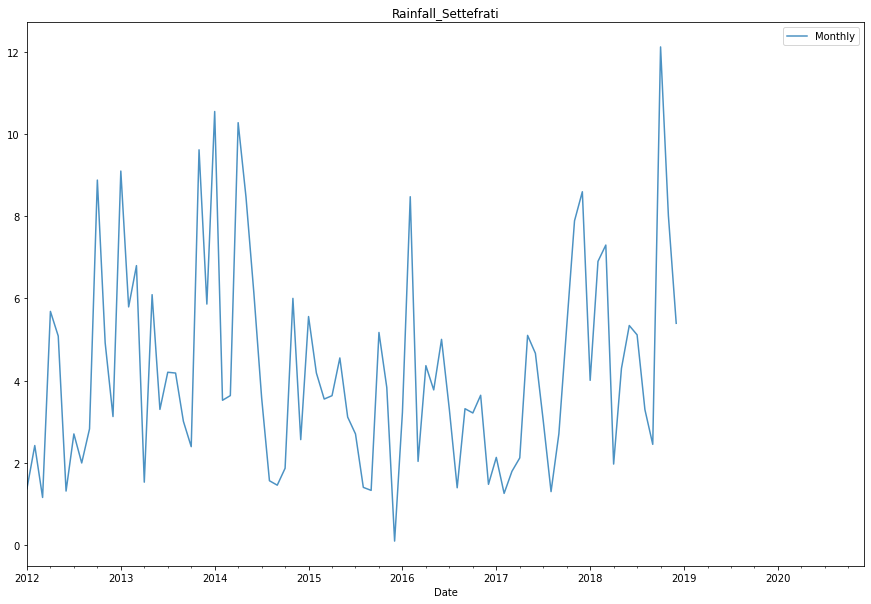

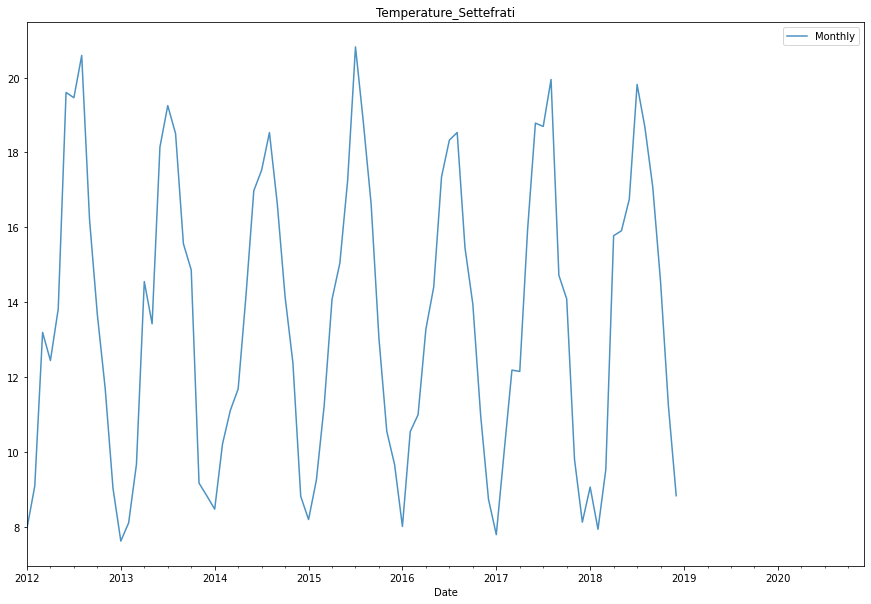

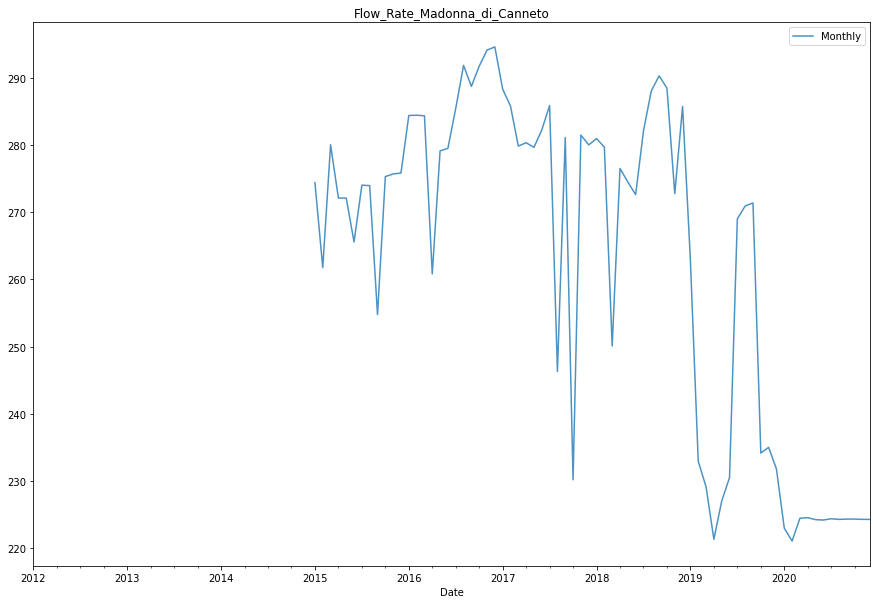

In [40]:
for col in wsmc.columns:
    plt.figure(figsize=(15,10))
    wsmc[col].resample('M').mean().plot(alpha=.8, label='Monthly')
    plt.title(col)
    plt.legend()

## Cleaning WSMC
Due to the amount of missing data before 2015 for flow rate, to make predictions we will ignore any year prior to 2016 and upsample all the data to the average monthly rate.

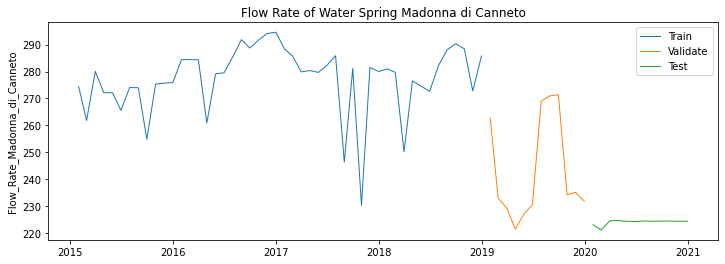

In [41]:
# reassign wsmc to ignore every year prior to 2016
clean_wsmc = wsmc[wsmc.index.year > 2014]
# then upsable to monthly average
clean_wsmc = clean_wsmc.resample('M').mean()

# then only grab the column Flow_Rate_Madonna_di_Canneto as there are two years of missing data for both tempature and rain fall
clean_wsmc = clean_wsmc[['Flow_Rate_Madonna_di_Canneto']]

# then split that data into train, validate, and test data sets
train = clean_wsmc[clean_wsmc.index.year < 2019]
validate = clean_wsmc[clean_wsmc.index.year == 2019]
test = clean_wsmc[clean_wsmc.index.year == 2020]

plt.figure(figsize=(12,4))
plt.plot(train['Flow_Rate_Madonna_di_Canneto'], label = 'Train', linewidth = 1)
plt.plot(validate['Flow_Rate_Madonna_di_Canneto'], label = 'Validate', linewidth = 1)
plt.plot(test['Flow_Rate_Madonna_di_Canneto'], label = 'Test', linewidth = 1)
plt.ylabel(col)
plt.title('Flow Rate of Water Spring Madonna di Canneto')
plt.legend()
plt.show()

In [42]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Prediction', linewidth = 2)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    

# Modeling WSMC

In [43]:
flow = train['Flow_Rate_Madonna_di_Canneto'][-1:][0]

yhat_df = pd.DataFrame({'Flow_Rate_Madonna_di_Canneto': [flow]}, 
                       index = validate.index)

yhat_df.head(2)

,Flow_Rate_Madonna_di_Canneto
Date,
2019-01-31,285.751341
2019-02-28,285.751341


Flow_Rate_Madonna_di_Canneto -- RMSE: 47


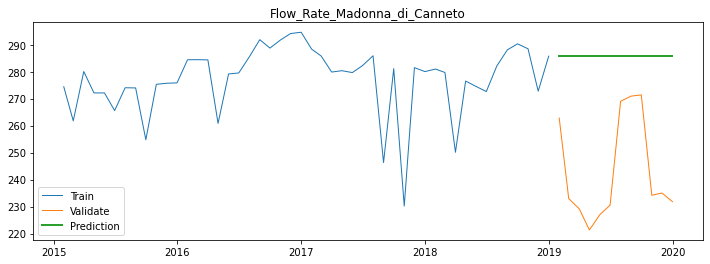

In [44]:
plot_and_eval('Flow_Rate_Madonna_di_Canneto')

In [45]:
# Due to continuing notebook clear our dataframe from eval
eval_df = pd.DataFrame()

eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'Flow_Rate_Madonna_di_Canneto')

eval_df

,model_type,target_var,rmse
0,last_observed_value,Flow_Rate_Madonna_di_Canneto,47.0


            Flow_Rate_Madonna_di_Canneto
Date                                    
2019-01-31                        277.47
2019-02-28                        277.47
Flow_Rate_Madonna_di_Canneto -- RMSE: 39


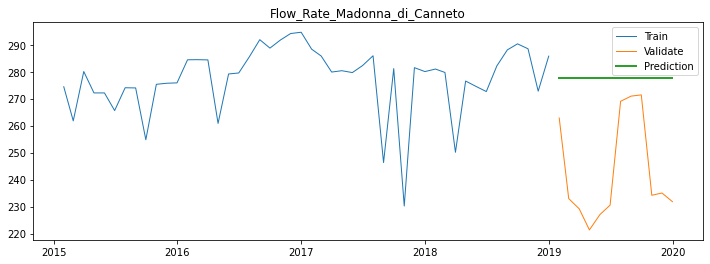

            model_type                    target_var  rmse
0  last_observed_value  Flow_Rate_Madonna_di_Canneto  47.0
1       simple_average  Flow_Rate_Madonna_di_Canneto  39.0


In [46]:
flow = round(train['Flow_Rate_Madonna_di_Canneto'].mean(), 2)

def make_predictions(target_variable):
    yhat_df = pd.DataFrame({target_variable: [flow],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions('Flow_Rate_Madonna_di_Canneto')

eval_df = append_eval_df(model_type='simple_average', target_var = 'Flow_Rate_Madonna_di_Canneto')


print(yhat_df.head(2))
plot_and_eval('Flow_Rate_Madonna_di_Canneto')

print(eval_df)

Flow_Rate_Madonna_di_Canneto -- RMSE: 43


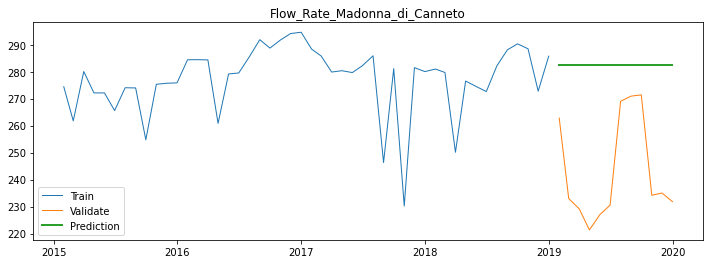

            model_type                    target_var  rmse
0  last_observed_value  Flow_Rate_Madonna_di_Canneto  47.0
1       simple_average  Flow_Rate_Madonna_di_Canneto  39.0
2  3 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  43.0


In [47]:
# Do a 3 Month rolling average

period = 3

flow = round(train['Flow_Rate_Madonna_di_Canneto'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions('Flow_Rate_Madonna_di_Canneto')

eval_df = append_eval_df(model_type='3 Month Rolling AVG', target_var = 'Flow_Rate_Madonna_di_Canneto')
    


plot_and_eval('Flow_Rate_Madonna_di_Canneto')

print(eval_df)

Flow_Rate_Madonna_di_Canneto -- RMSE: 45


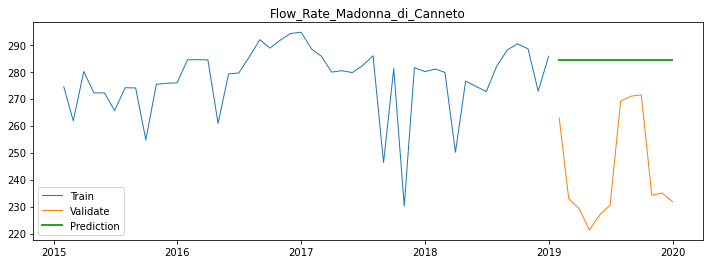

            model_type                    target_var  rmse
0  last_observed_value  Flow_Rate_Madonna_di_Canneto  47.0
1       simple_average  Flow_Rate_Madonna_di_Canneto  39.0
2  3 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  43.0
3  4 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  45.0


In [48]:
# Do a 4 Month rolling average

period = 4

flow = round(train['Flow_Rate_Madonna_di_Canneto'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions('Flow_Rate_Madonna_di_Canneto')

eval_df = append_eval_df(model_type='4 Month Rolling AVG', target_var = 'Flow_Rate_Madonna_di_Canneto')
    


plot_and_eval('Flow_Rate_Madonna_di_Canneto')

print(eval_df)

Flow_Rate_Madonna_di_Canneto -- RMSE: 46


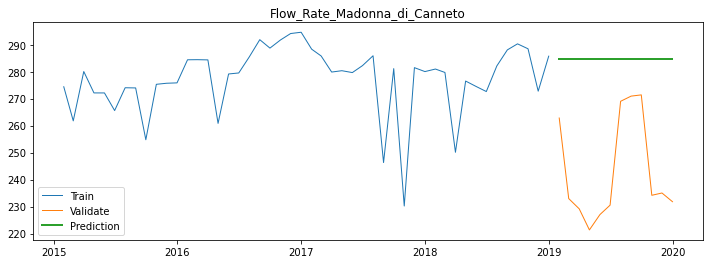

            model_type                    target_var  rmse
0  last_observed_value  Flow_Rate_Madonna_di_Canneto  47.0
1       simple_average  Flow_Rate_Madonna_di_Canneto  39.0
2  3 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  43.0
3  4 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  45.0
4  6 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  46.0


In [49]:
# Do a 6 Month rolling average

period = 6

flow = round(train['Flow_Rate_Madonna_di_Canneto'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions('Flow_Rate_Madonna_di_Canneto')

eval_df = append_eval_df(model_type='6 Month Rolling AVG', target_var = 'Flow_Rate_Madonna_di_Canneto')
    


plot_and_eval('Flow_Rate_Madonna_di_Canneto')

print(eval_df)

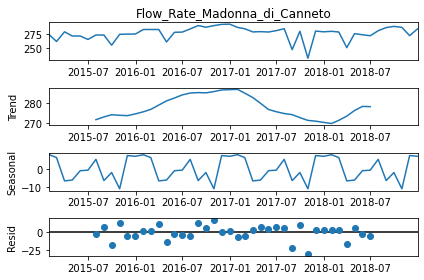

In [50]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train['Flow_Rate_Madonna_di_Canneto'].resample('M').mean()).plot()
plt.show()

Flow_Rate_Madonna_di_Canneto -- RMSE: 54


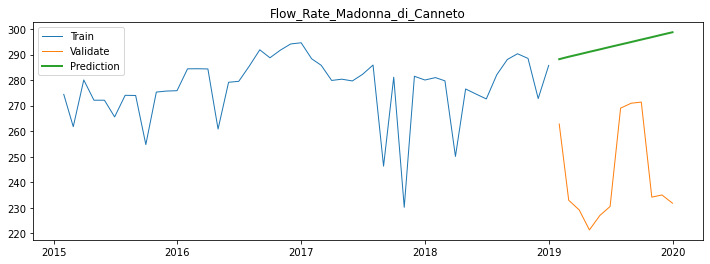

            model_type                    target_var  rmse
0  last_observed_value  Flow_Rate_Madonna_di_Canneto  47.0
1       simple_average  Flow_Rate_Madonna_di_Canneto  39.0
2  3 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  43.0
3  4 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  45.0
4  6 Month Rolling AVG  Flow_Rate_Madonna_di_Canneto  46.0
5                Holts  Flow_Rate_Madonna_di_Canneto  54.0


In [51]:
model = Holt(train['Flow_Rate_Madonna_di_Canneto'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_df = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['Flow_Rate_Madonna_di_Canneto'] = round(yhat_df, 2)


eval_df = append_eval_df(model_type='Holts', target_var = 'Flow_Rate_Madonna_di_Canneto')

plot_and_eval('Flow_Rate_Madonna_di_Canneto')

print(eval_df)

Flow_Rate_Madonna_di_Canneto -- RMSE: 40


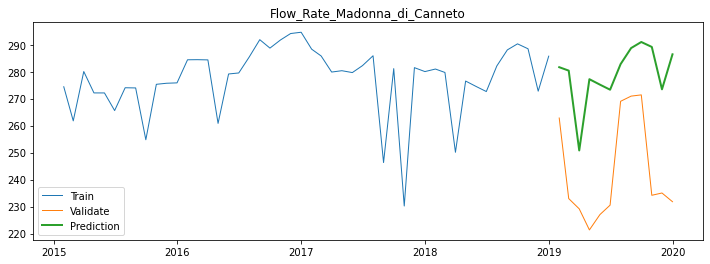

In [52]:
# Calculate the 3 month difference and plot the results from train

yhat_df = train['2018'] + train.diff(3).mean()

# set the yhat_df.index to the validate.index
yhat_df.index = validate.index

# evaluate 
plot_and_eval('Flow_Rate_Madonna_di_Canneto')
eval_df = append_eval_df(model_type = 'previous 3 months', target_var = col)


Flow_Rate_Madonna_di_Canneto -- RMSE: 40


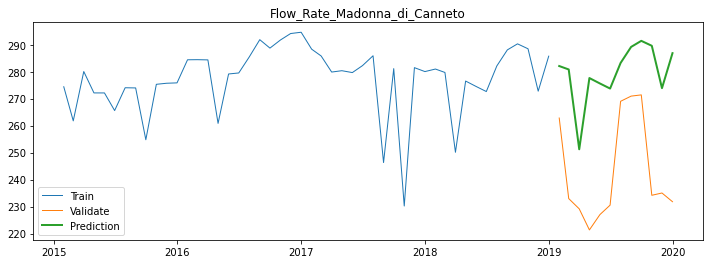

In [53]:
# Calculate the 4 month difference and plot the results from train

yhat_df = train['2018'] + train.diff(4).mean()

# set the yhat_df.index to the validate.index
yhat_df.index = validate.index

plot_and_eval('Flow_Rate_Madonna_di_Canneto')
eval_df = append_eval_df(model_type = 'previous 4 months', target_var = col)

Flow_Rate_Madonna_di_Canneto -- RMSE: 41


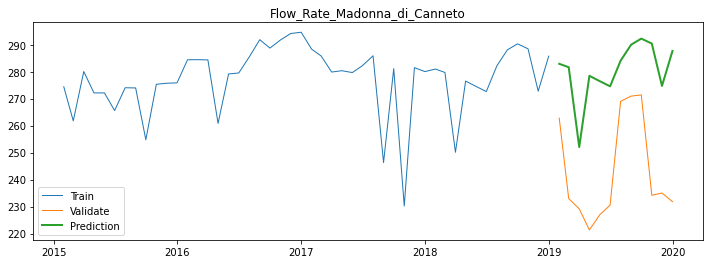

In [54]:
# Calculate the 4 month difference and plot the results from train


yhat_df = train['2018'] + train.diff(6).mean()

# set the yhat_df.index to the validate.index
yhat_df.index = validate.index

plot_and_eval('Flow_Rate_Madonna_di_Canneto')
eval_df = append_eval_df(model_type = 'previous 6 months', target_var = col)

In [55]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Flow_Rate_Madonna_di_Canneto,47.0
1,simple_average,Flow_Rate_Madonna_di_Canneto,39.0
2,3 Month Rolling AVG,Flow_Rate_Madonna_di_Canneto,43.0
3,4 Month Rolling AVG,Flow_Rate_Madonna_di_Canneto,45.0
4,6 Month Rolling AVG,Flow_Rate_Madonna_di_Canneto,46.0
5,Holts,Flow_Rate_Madonna_di_Canneto,54.0
6,previous 3 months,Flow_Rate_Madonna_di_Canneto,40.0
7,previous 4 months,Flow_Rate_Madonna_di_Canneto,40.0
8,previous 6 months,Flow_Rate_Madonna_di_Canneto,41.0


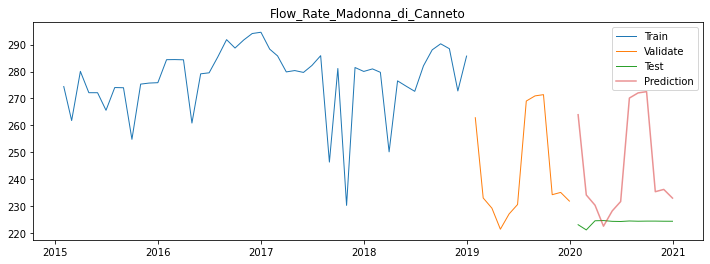

In [56]:
yhat_df = validate + train.diff(4).mean()
yhat_df.index = test.index

rmse_dollars = round(sqrt(mean_squared_error(test['Flow_Rate_Madonna_di_Canneto'], yhat_df['Flow_Rate_Madonna_di_Canneto'])), 0)


def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], label='Prediction', alpha = .5)
    plt.title(target_var)
    plt.legend()
    plt.show()

plot_and_eval('Flow_Rate_Madonna_di_Canneto')


We need to test for correlation and predictive power of rain and tempature on flow rate as our flow rate models didn't do well. The only years we can do this on are 2015 - 2019. Let's create a dataframe for only testing the corraltion of these years. If there is statistically significant corraltion between either of these, then the next step will be to make a series of models that predicts the known values and use the one that is best to predict the unknown values.

In [57]:
test_corr = wsmc[(wsmc.index.year >= 2015) & (wsmc.index.year <= 2018)].resample('M').mean()
test_corr

,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
Date,,,
2015-01-31,5.558065,8.191935,274.413138
2015-02-28,4.185714,9.244643,261.762449
2015-03-31,3.551613,11.243548,280.058585
2015-04-30,3.633333,14.075000,272.124569
2015-05-31,4.551613,15.041935,272.116613
2015-06-30,3.113333,17.258333,265.580058
2015-07-31,2.703226,20.817742,274.042693
2015-08-31,1.403226,18.812903,273.969763
2015-09-30,1.330000,16.618333,254.767775


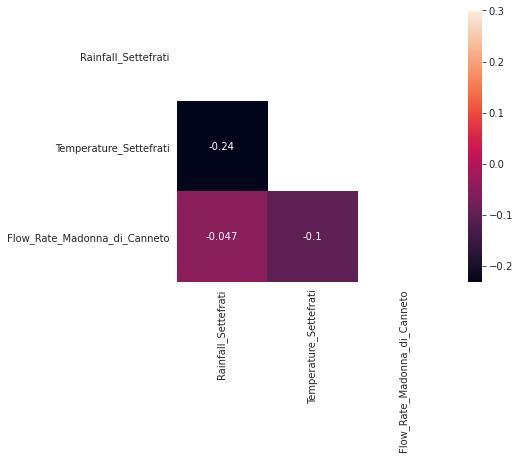

In [58]:
corr = test_corr.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, robust=True)

There is a very slight corralation between rain fall and flow rate. There does not appear to be corraltion between tempature and rain fall or tempature and flow rate. As such, we will only attempt to make predictions using rain fall for this data set. 

In [59]:
# reassign wsmc to ignore every year prior to 2016
clean_wsmc = wsmc[wsmc.index.year > 2014]
# then upsable to monthly average
clean_wsmc = clean_wsmc.resample('M').mean()

# then split that data into train, validate, and test data sets
train = clean_wsmc[clean_wsmc.index.year < 2019]
validate = clean_wsmc[clean_wsmc.index.year == 2019]
test = clean_wsmc[clean_wsmc.index.year == 2020]

train

,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
Date,,,
2015-01-31,5.558065,8.191935,274.413138
2015-02-28,4.185714,9.244643,261.762449
2015-03-31,3.551613,11.243548,280.058585
2015-04-30,3.633333,14.075000,272.124569
2015-05-31,4.551613,15.041935,272.116613
2015-06-30,3.113333,17.258333,265.580058
2015-07-31,2.703226,20.817742,274.042693
2015-08-31,1.403226,18.812903,273.969763
2015-09-30,1.330000,16.618333,254.767775


In [60]:
# Splits the target from the data sets for modeling 
X_train = train[['Rainfall_Settefrati']]
X_validate = validate[['Rainfall_Settefrati']]
X_test = test[['Rainfall_Settefrati']]

y_train = train[['Flow_Rate_Madonna_di_Canneto']]
y_validate = validate[['Flow_Rate_Madonna_di_Canneto']]
y_test = test[['Flow_Rate_Madonna_di_Canneto']]

#Print to make sure it took
X_train

,Rainfall_Settefrati
Date,
2015-01-31,5.558065
2015-02-28,4.185714
2015-03-31,3.551613
2015-04-30,3.633333
2015-05-31,4.551613
2015-06-30,3.113333
2015-07-31,2.703226
2015-08-31,1.403226
2015-09-30,1.330000


In [61]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, Ridge
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt

lm1 = LinearRegression()
lm1.fit(X_train, y_train.Flow_Rate_Madonna_di_Canneto)
y_hat = lm1.predict(X_train)

y_train['lm_1'] = y_hat

lm1_mse = mean_squared_error(y_train.Flow_Rate_Madonna_di_Canneto, y_hat)
lm1_rmse = mean_squared_error(y_train.Flow_Rate_Madonna_di_Canneto, y_hat)**(1/2)

print('LM1 Mean Squared Error:', (lm1_mse))
print('LM1 Root Mean Squared Error:', (lm1_rmse))

LM1 Mean Squared Error: 155.21698539816114
LM1 Root Mean Squared Error: 12.458610893601307


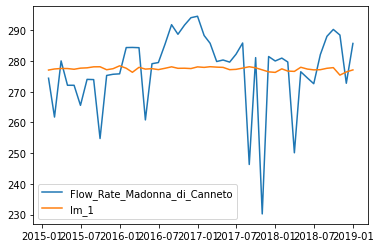

In [64]:
for col in y_train.columns:
    plt.plot(y_train[col], label=col)
    plt.legend()

LM1 Mean Squared Error: 155.2169904812558
LM1 Root Mean Squared Error: 12.458611097600558


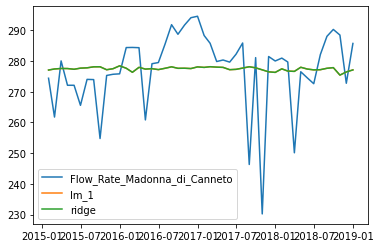

In [65]:
ridge = Ridge()
ridge.fit(X_train, y_train.Flow_Rate_Madonna_di_Canneto)
y_hat = ridge.predict(X_train)

y_train['ridge'] = y_hat

ridge_mse = mean_squared_error(y_train.Flow_Rate_Madonna_di_Canneto, y_hat)
ridge_rmse = mean_squared_error(y_train.Flow_Rate_Madonna_di_Canneto, y_hat)**(1/2)

print('LM1 Mean Squared Error:', (ridge_mse))
print('LM1 Root Mean Squared Error:', (ridge_rmse))

for col in y_train.columns:
    plt.plot(y_train[col], label=col)
    plt.legend()